In [1]:
import os
import sys
import gym
import random
import numpy as np
import pandas as pd
from itertools import count
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import timedelta
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [2]:
seed = 1

os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。

random.seed(seed)
np.random.seed(seed)

# env.seed(seed)  这个等创建了环境之后再设置

torch.manual_seed(seed)            # 为CPU设置随机种子
torch.cuda.manual_seed(seed)       # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)   # 为所有GPU设置随机种子

In [3]:
path = os.path.abspath('..')
if path not in sys.path:
    sys.path.append(path)

In [4]:
from configs import Config
from networks_pytorch import PGbaselineCategoricalNetwork
from agents_pytorch import PGbaselineAgent

# Training Loop

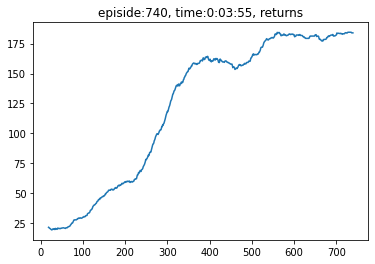

Solved! eval return is now 195.25!


In [5]:
name = 'CartPole-v0'
env_eval = gym.make(name)
env_eval.seed(seed)

config = Config()
config.lr = 1e-3

start = timer()
running_returns = []
agent_pgbaseline = PGbaselineAgent(env_name=name, policy=PGbaselineCategoricalNetwork, config=config)

for episode in count(1): # 一直加1的while, 表示一条episode
    # print('episode%d'%episode)
    obs, ep_return = agent_pgbaseline.env.reset(), 0
    for step in range(10000):
        action = agent_pgbaseline.get_action(obs)
        obs, reward, done, _ = agent_pgbaseline.env.step(action)
        agent_pgbaseline.rewards.append(reward)
        ep_return += reward
        if done:
            running_returns.append(ep_return)
            break
            
    agent_pgbaseline.compute_return()
    
    if episode % 1 == 0:          # 每1条轨迹进行一次梯度更新，当然也可以设置一个batch_size，就相当与stochastic和mini-batch gradient descent的区别
        agent_pgbaseline.train()
    
    
    if episode % 10 == 0:
        clear_output(True)
        plt.plot(pd.Series(running_returns).rolling(100, 20).mean())
        plt.title('episide:{}, time:{}, returns'.format(episode, timedelta(seconds=int(timer()-start))))
        plt.show()
    if np.array(running_returns)[-20:].mean() > 195:
        eval_return = agent_pgbaseline.eval_(env_eval, 100)
        if eval_return > 195:
            print("Solved! eval return is now {}!".format(eval_return))
            break 

In [6]:
eval_return = agent_pgbaseline.eval_(env_eval, 100)
print(eval_return)

193.48


In [8]:
torch.save(agent_pgbaseline.policy.state_dict(), './PGbaseline_cartpole.pt')

In [10]:
torch.save(agent_pgbaseline.policy.state_dict(), './PGbaseline_cartpole.pt')